# Comparing XGB, Jax, Torch

Compare MLPs in Jax and Torch against XGB.

# Setup

In [1]:
from time import time

import jax
import seaborn as sns
import wandb
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import xjax
from xjax.signals import train_epoch_completed

In [2]:
rng = jax.random.key(xjax.tools.seed())

In [3]:
capture_metrics = True

# Config

In [4]:
# Hyperparameters
n_samples = 10000
hiddens = [5, 5, 5]
batch_size = 10
epochs = 10
learning_rate = 0.01

In [5]:
if capture_metrics:
    wandb.init(
        project="xgb-jax-torch",
        config={
            "n_samples": n_samples,
            "hiddens": hiddens,
            "batch_size": batch_size,
            "epochs": epochs,
            "learning_rate": learning_rate,
        },
    )

wandb: Currently logged in as: andrewsomesyoung (andrewsomesyoung-projects). Use `wandb login --relogin` to force relogin


# Dataset

In [6]:
# Generate circle dataset
rng, dataset_rng = jax.random.split(rng)
X, y = xjax.datasets.sphere(rng=dataset_rng, n=n_samples)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

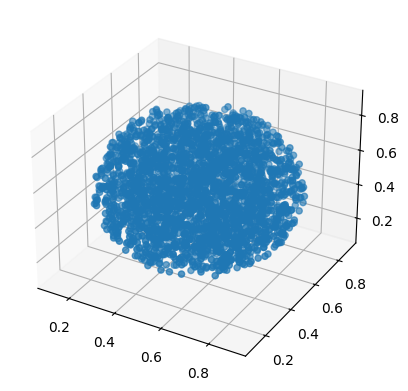

In [7]:
fig = plt.figure()

mask = y == 1.0
X_positive = X[mask]
y_positive = y[mask]
ax = fig.add_subplot(projection="3d")
ax.scatter(X_positive[:, 0], X_positive[:, 1], X_positive[:, 2])

# Modeling

## XGB

In [8]:
# Construct model
model_xgb = xjax.models.sklearn.xgb_classifier()

In [9]:
# Train model
start_time = time()
model_xgb = xjax.models.sklearn.train(model_xgb, X=X_train, y=y_train)
elapsed = (time() - start_time)

if capture_metrics:
    wandb.log({"elapsed_xgb": elapsed})

In [10]:
# Test model
y_score_xgb = xjax.models.sklearn.predict(model_xgb, X=X_test)
auroc_xgb = roc_auc_score(y_test, y_score_xgb)

if capture_metrics:
    wandb.log({"auroc_xgb": auroc_xgb})

print(f"XGB AUROC: {auroc_xgb:0.4f}")

XGB AUROC: 0.9988


## Jax

In [11]:
# Construct model
rng, model_rng = jax.random.split(rng)
model_jax, params = xjax.models.flax.mlp(rng=model_rng, inputs=3, hiddens=hiddens)

In [12]:
# Monitor model
@train_epoch_completed.connect_via(model_jax)
def monitor_model(model, epoch, loss, **_):
    elapsed = (time() - start_time)
    loss_hx.append(loss)
    xjax.plots.loss_history(loss_hx, elapsed=elapsed)

    if capture_metrics:
        wandb.log({"epoch": epoch, "loss_jax": loss, "elapsed_jax": elapsed})

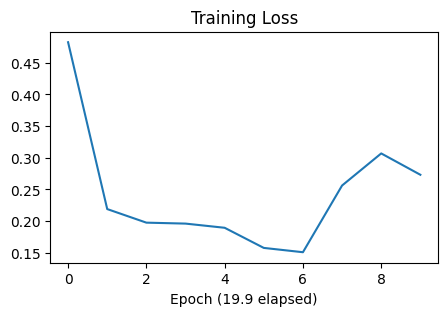

In [13]:
start_time = time()
loss_hx = []

# Train model
params = xjax.models.flax.train(
    model_jax,
    params=params,
    X=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    learning_rate=learning_rate,
)

In [14]:
# Test model
y_score_jax = xjax.models.flax.predict(model_jax, params=params, X=X_test)
auroc_jax = roc_auc_score(y_test, y_score_jax)

if capture_metrics:
    wandb.log({"auroc_jax": auroc_jax})

print(f"Jax AUROC: {auroc_jax:0.4f}")

Jax AUROC: 0.9931


## Torch

In [15]:
# Construct model
model_torch = xjax.models.torch.mlp(inputs=3, hiddens=hiddens)

In [16]:
# Monitor model
@train_epoch_completed.connect_via(model_torch)
def monitor_model(model, epoch, loss, **_):
    loss = loss.detach().numpy()
    elapsed = (time() - start_time)
    
    loss_hx.append(loss)
    xjax.plots.loss_history(loss_hx, elapsed=elapsed)

    if capture_metrics:
        wandb.log({"epoch": epoch, "loss_torch": loss, "elapsed_torch": elapsed})

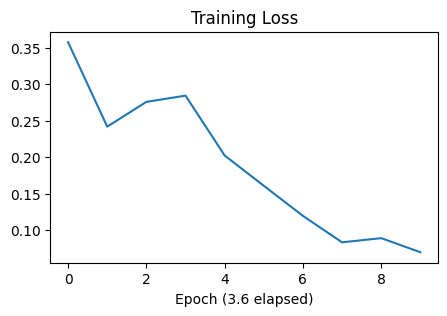

In [17]:
start_time = time()
loss_hx = []

# Train model
model_torch = xjax.models.torch.train(
    model_torch,
    X=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    learning_rate=learning_rate,
)

In [18]:
# Test model
y_score_torch = xjax.models.torch.predict(model_torch, X=X_test)
auroc_torch = roc_auc_score(y_test, y_score_torch)

if capture_metrics:
    wandb.log({"auroc_torch": auroc_torch})

print(f"Torch AUROC: {auroc_torch:0.4f}")

Torch AUROC: 0.9906


# Analysis

## Predictions

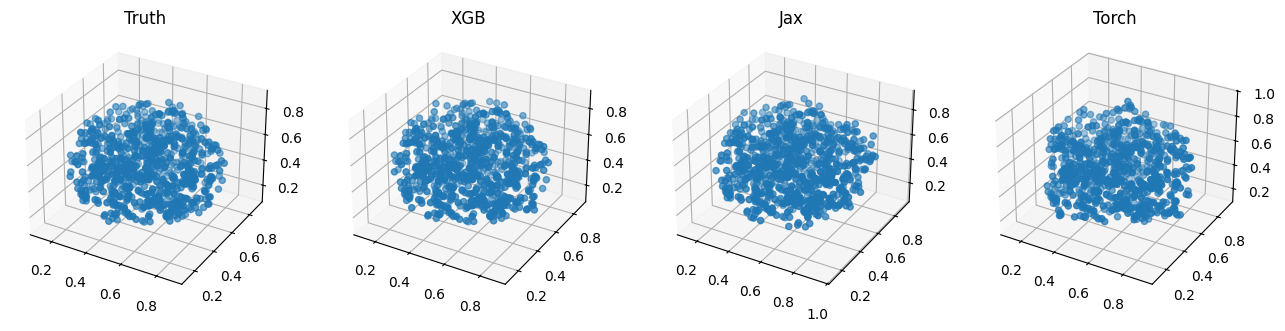

In [19]:
y_pred_xgb = (y_score_xgb > 0.5).astype(int)
y_pred_jax = (y_score_jax > 0.5).astype(int)
y_pred_torch = (y_score_torch > 0.5).numpy().astype(int)

fig = plt.figure()
fig.set_size_inches(16, 4)

mask = (y_test == 1.0)
X_positive = X_test[mask]
ax = fig.add_subplot(141, projection="3d")
ax.scatter(X_positive[:, 0], X_positive[:, 1], X_positive[:, 2])
ax.set_title("Truth")

mask = (y_pred_xgb == 1.0)
X_positive = X_test[mask]
ax = fig.add_subplot(142, projection="3d")
ax.scatter(X_positive[:, 0], X_positive[:, 1], X_positive[:, 2])
ax.set_title("XGB")

mask = (y_pred_jax == 1.0)
X_positive = X_test[mask]
ax = fig.add_subplot(143, projection="3d")
ax.scatter(X_positive[:, 0], X_positive[:, 1], X_positive[:, 2])
ax.set_title("Jax")

mask = (y_pred_torch == 1.0)
X_positive = X_test[mask]
ax = fig.add_subplot(144, projection="3d")
ax.scatter(X_positive[:, 0], X_positive[:, 1], X_positive[:, 2])
ax.set_title("Torch")

if capture_metrics:
    wandb.log({"predictions": wandb.Image(plt)})

## ROC Curves

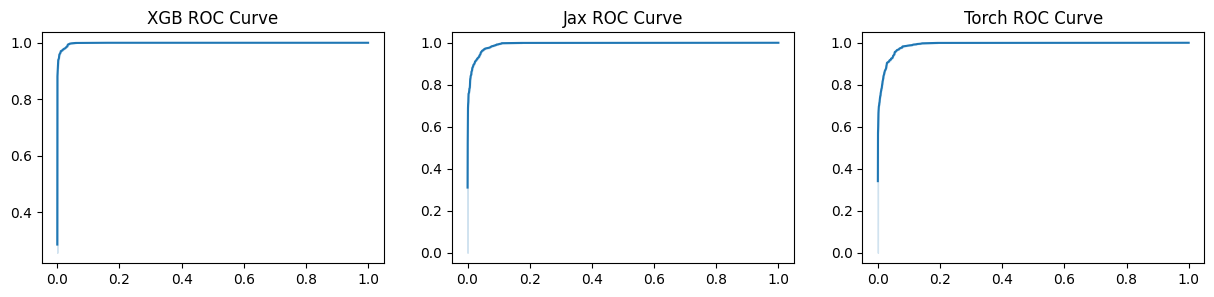

In [20]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
fpr_jax, tpr_jax, _ = roc_curve(y_test, y_score_jax)
fpr_torch, tpr_torch, _ = roc_curve(y_test, y_score_torch)

fig, axs = plt.subplots(ncols=3, figsize=(15, 3))

sns.lineplot(x=fpr_xgb, y=tpr_xgb, ax=axs[0])
axs[0].set_title("XGB ROC Curve")

sns.lineplot(x=fpr_jax, y=tpr_jax, ax=axs[1])
axs[1].set_title("Jax ROC Curve")

sns.lineplot(x=fpr_torch, y=tpr_torch, ax=axs[2])
axs[2].set_title("Torch ROC Curve")

if capture_metrics:
    wandb.log({"roc_curve": wandb.Image(plt)})

In [21]:
if capture_metrics:
    wandb.finish()

auroc_jax,▁
auroc_torch,▁
auroc_xgb,▁
elapsed_jax,▁▂▃▃▄▅▆▆▇█
elapsed_torch,▁▂▃▃▄▅▆▆▇█
elapsed_xgb,▁
epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
loss_jax,█▂▂▂▂▁▁▃▄▄
loss_torch,█▅▆▆▄▃▂▁▁▁
auroc_jax,0.99311
auroc_torch,0.99057
